# Stylometric Signature Extraction

In [49]:
import pandas as pd
import numpy as np
import spacy
from collections import Counter
from itertools import pairwise
from textstat import flesch_reading_ease
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm



In [50]:
# Carica il modello spaCy
nlp = spacy.load("en_core_web_sm")

# Carica il dataset pulito
df_clean = pd.read_csv('ai_human_clean.csv')
print(f"Dataset caricato: {df_clean.shape[0]} righe, {df_clean.shape[1]} colonne")

Dataset caricato: 500 righe, 39 colonne


## Utility functions

In [51]:
def sentence_lengths(doc):
    """Estrae lunghezze delle frasi"""
    return np.array([len(sent) for sent in doc.sents if len(sent) > 0])

def coefficient_of_variation(x):
    """CV = std/mean - misura variabilità relativa"""
    return np.std(x) / np.mean(x) if np.mean(x) > 0 else 0.0

def burstiness_index(x):
    """Burstiness = (σ - μ) / (σ + μ) - irregolarità temporale"""
    mu, sigma = np.mean(x), np.std(x)
    return (sigma - mu) / (sigma + mu) if (sigma + mu) > 0 else 0.0

## R — Rhythmic Control

In [52]:
def rhythmic_features(doc):
    """Firma del ritmo: variabilità lunghezza frasi"""
    lengths = sentence_lengths(doc)
    return {
        "sentence_length_cv": coefficient_of_variation(lengths),
        "burstiness_index": burstiness_index(lengths)
    }

## S — Syntactic Entropy

In [53]:
def pos_bigram_entropy(doc):
    """Entropia delle transizioni POS (Part-of-Speech)"""
    pos_tags = [token.pos_ for token in doc]
    bigrams = list(pairwise(pos_tags))
    counts = Counter(bigrams)
    probs = np.array(list(counts.values())) / sum(counts.values()) if counts else [1.0]
    return entropy(probs)

def dependency_depth_mean(doc):
    """Profondità media albero sintattico"""
    depths = []
    for sent in doc.sents:
        for token in sent:
            depth, current = 0, token
            while current.head != current:
                depth += 1
                current = current.head
            depths.append(depth)
    return np.mean(depths) if depths else 0.0

def syntactic_features(doc):
    """Firma sintattica: complessità strutturale"""
    return {
        "pos_bigram_entropy": pos_bigram_entropy(doc),
        "dependency_depth_mean": dependency_depth_mean(doc)
    }


## L — Lexical Efficiency

In [54]:
def lexical_features(doc):
    """Firma lessicale: efficienza comunicativa"""
    tokens = [t for t in doc if t.is_alpha]
    lemmas = [t.lemma_ for t in tokens]
    function_words = [t for t in tokens if t.pos_ in {"DET", "ADP", "AUX", "PRON", "CCONJ", "SCONJ"}]

    return {
        "lexical_compression_ratio": len(set(lemmas)) / len(tokens) if tokens else 0.0,
        "function_word_ratio": len(function_words) / len(tokens) if tokens else 0.0
    }

## D — Discourse Regularization


In [55]:
def sentence_similarity_drift(doc):
    """Drift semantico tra frasi consecutive"""
    sentences = [sent.text for sent in doc.sents]
    if len(sentences) < 2:
        return 0.0

    vectors = np.array([nlp(sent).vector for sent in sentences])
    sims = [cosine_similarity([vectors[i]], [vectors[i + 1]])[0][0]
            for i in range(len(vectors) - 1)]
    return float(np.mean(sims))

def structural_redundancy(doc):
    """Ridondanza pattern sintattici"""
    patterns = []
    for sent in doc.sents:
        pattern = tuple(tok.dep_ for tok in sent)
        patterns.append(pattern)
    counts = Counter(patterns)
    repeated = sum(c for c in counts.values() if c > 1)
    return repeated / len(patterns) if patterns else 0.0

def discourse_features(doc):
    """Firma del discorso: coesione e ridondanza"""
    return {
        "sentence_similarity_drift": sentence_similarity_drift(doc),
        "structural_redundancy": structural_redundancy(doc)
    }

## E — Emotional Variance

In [56]:
def fast_sentiment(text):
    """Sentiment rapido con TextBlob"""
    return TextBlob(text).sentiment.polarity

def emotional_features(doc, sentiment_fn):
    """Firma emotiva: varianza polarità"""
    sentiments = []
    for sent in doc.sents:
        score = sentiment_fn(sent.text)
        sentiments.append(score)
    return {
        "sentiment_variance": np.std(sentiments) if sentiments else 0.0
    }

## C — Cognitive Load Distribution

In [57]:
def cognitive_features(doc):
    """Firma cognitiva: complessità lettura"""
    readability = []
    for sent in doc.sents:
        try:
            score = flesch_reading_ease(sent.text)
            readability.append(score)
        except:
            pass
    
    sub_clauses = sum(1 for tok in doc if tok.dep_ in {"advcl", "ccomp", "xcomp", "relcl"})
    sentences = len(list(doc.sents))

    return {
        "readability_oscillation": np.std(readability) if readability else 0.0,
        "clause_density": sub_clauses / sentences if sentences > 0 else 0.0
    }

## Stylometric Signature

In [58]:
def shuffle_text(text):
    tokens = text.split()
    if len(tokens) < 5:
        return text
    np.random.shuffle(tokens)
    return " ".join(tokens)


def normalize_with_shuffle(feature_fn, text, n_shuffles=5):
    """
    Computes feature normalization against shuffled baselines.
    f* = (f - mean(f_shuffle)) / std(f_shuffle)
    """
    original = feature_fn(text)
    shuffled_vals = []

    for _ in range(n_shuffles):
        shuffled_text = shuffle_text(text)
        shuffled_vals.append(feature_fn(shuffled_text))

    mu = np.mean(shuffled_vals)
    sigma = np.std(shuffled_vals)

    if sigma == 0:
        return 0.0
    return (original - mu) / sigma



In [59]:
def extract_stylometric_signature(text, sentiment_fn):
    """
    Estrae la firma stilometrica completa (10 feature).
    Ottimizzata per velocità.
    """
    try:
        # Parsing spaCy (disabilitiamo NER per velocità)
        with nlp.select_pipes(disable=["ner"]):
            doc = nlp(text[:5000])  # Limita a 5000 char per performance
        
        # Estrai tutte le feature
        features = {}
        features.update(rhythmic_features(doc))
        features.update(syntactic_features(doc))
        features.update(lexical_features(doc))
        features.update(discourse_features(doc))
        features.update(emotional_features(doc, sentiment_fn))
        features.update(cognitive_features(doc))
        
        return features
    
    except Exception as e:
        # Fallback: restituisci feature nulle
        return {
            "sentence_length_cv": 0.0,
            "burstiness_index": 0.0,
            "pos_bigram_entropy": 0.0,
            "dependency_depth_mean": 0.0,
            "lexical_compression_ratio": 0.0,
            "function_word_ratio": 0.0,
            "sentence_similarity_drift": 0.0,
            "structural_redundancy": 0.0,
            "sentiment_variance": 0.0,
            "readability_oscillation": 0.0,
            "clause_density": 0.0
        }


## applicazione al dataset 

In [60]:
print("\n[3/6] Estrazione signature stilometriche...")
print("⏳ Questa operazione può richiedere 5-10 minuti...")

# Applica con progress bar
tqdm.pandas(desc="Processing texts")
signatures = df_clean['text_cleaned'].progress_apply(
    lambda text: extract_stylometric_signature(text, fast_sentiment)
)

# Converti in DataFrame
signature_df = pd.DataFrame(list(signatures))

print(f"\n✅ Signature estratte: {signature_df.shape[1]} feature")
print(f"   Feature list: {', '.join(signature_df.columns)}")



[3/6] Estrazione signature stilometriche...
⏳ Questa operazione può richiedere 5-10 minuti...


Processing texts: 100%|██████████| 500/500 [00:04<00:00, 111.88it/s]


✅ Signature estratte: 11 feature
   Feature list: sentence_length_cv, burstiness_index, pos_bigram_entropy, dependency_depth_mean, lexical_compression_ratio, function_word_ratio, sentence_similarity_drift, structural_redundancy, sentiment_variance, readability_oscillation, clause_density


In [61]:
print("\n[4/6] Merge con dataset originale...")
df_final = pd.concat([df_clean, signature_df], axis=1)

print(f"✅ Dataset finale: {df_final.shape[0]} righe, {df_final.shape[1]} colonne")



[4/6] Merge con dataset originale...
✅ Dataset finale: 500 righe, 50 colonne


### VALIDAZIONE: CONFRONTO AI vs HUMAN

In [62]:
print("\n[5/6] Validazione: Confronto signature AI vs Human")
print("=" * 70)

# 1. Calcolo aggregato
comparison = df_final.groupby('label_encoded')[signature_df.columns].agg(['mean', 'std'])

# 2. Estraiamo solo le medie usando .xs (Seleziona 'mean' dal livello 1 delle colonne)
means = comparison.xs('mean', axis=1, level=1)

print("\n📊 MEDIE PER CLASSE:")
print(means.round(3).to_string())

print("\n📊 DIFFERENZA ASSOLUTA (AI - Human):")
# Assicurati che gli indici 0 e 1 esistano (0=Human, 1=AI)
if 1 in means.index and 0 in means.index:
    diff = means.loc[1] - means.loc[0]
    print(diff.sort_values(ascending=False).round(3).to_string())

    # 3. Identifica le top 3 feature più discriminanti
    top_discriminant = diff.abs().sort_values(ascending=False).head(3)
    print(f"\n🎯 TOP 3 FEATURE DISCRIMINANTI:")
    for feat, value in top_discriminant.items():
        direction = "più alta in AI" if diff[feat] > 0 else "più alta in Human"
        print(f"   • {feat}: Δ = {abs(value):.3f} ({direction})")
else:
    print("⚠️ Errore: Classi 0 o 1 non trovate nel dataset.")


[5/6] Validazione: Confronto signature AI vs Human

📊 MEDIE PER CLASSE:
               sentence_length_cv  burstiness_index  pos_bigram_entropy  dependency_depth_mean  lexical_compression_ratio  function_word_ratio  sentence_similarity_drift  structural_redundancy  sentiment_variance  readability_oscillation  clause_density
label_encoded                                                                                                                                                                                                                                                
0                           0.110            -0.838               2.568                  1.957                      0.964                0.361                      0.155                    0.0               0.051                    7.663           0.989
1                           0.078            -0.879               2.392                  1.744                      0.969                0.345                      0

### VISUALIZZAZIONE


[6/6] Generazione visualizzazione...
✅ Visualizzazione salvata: 'signature_validation.png'


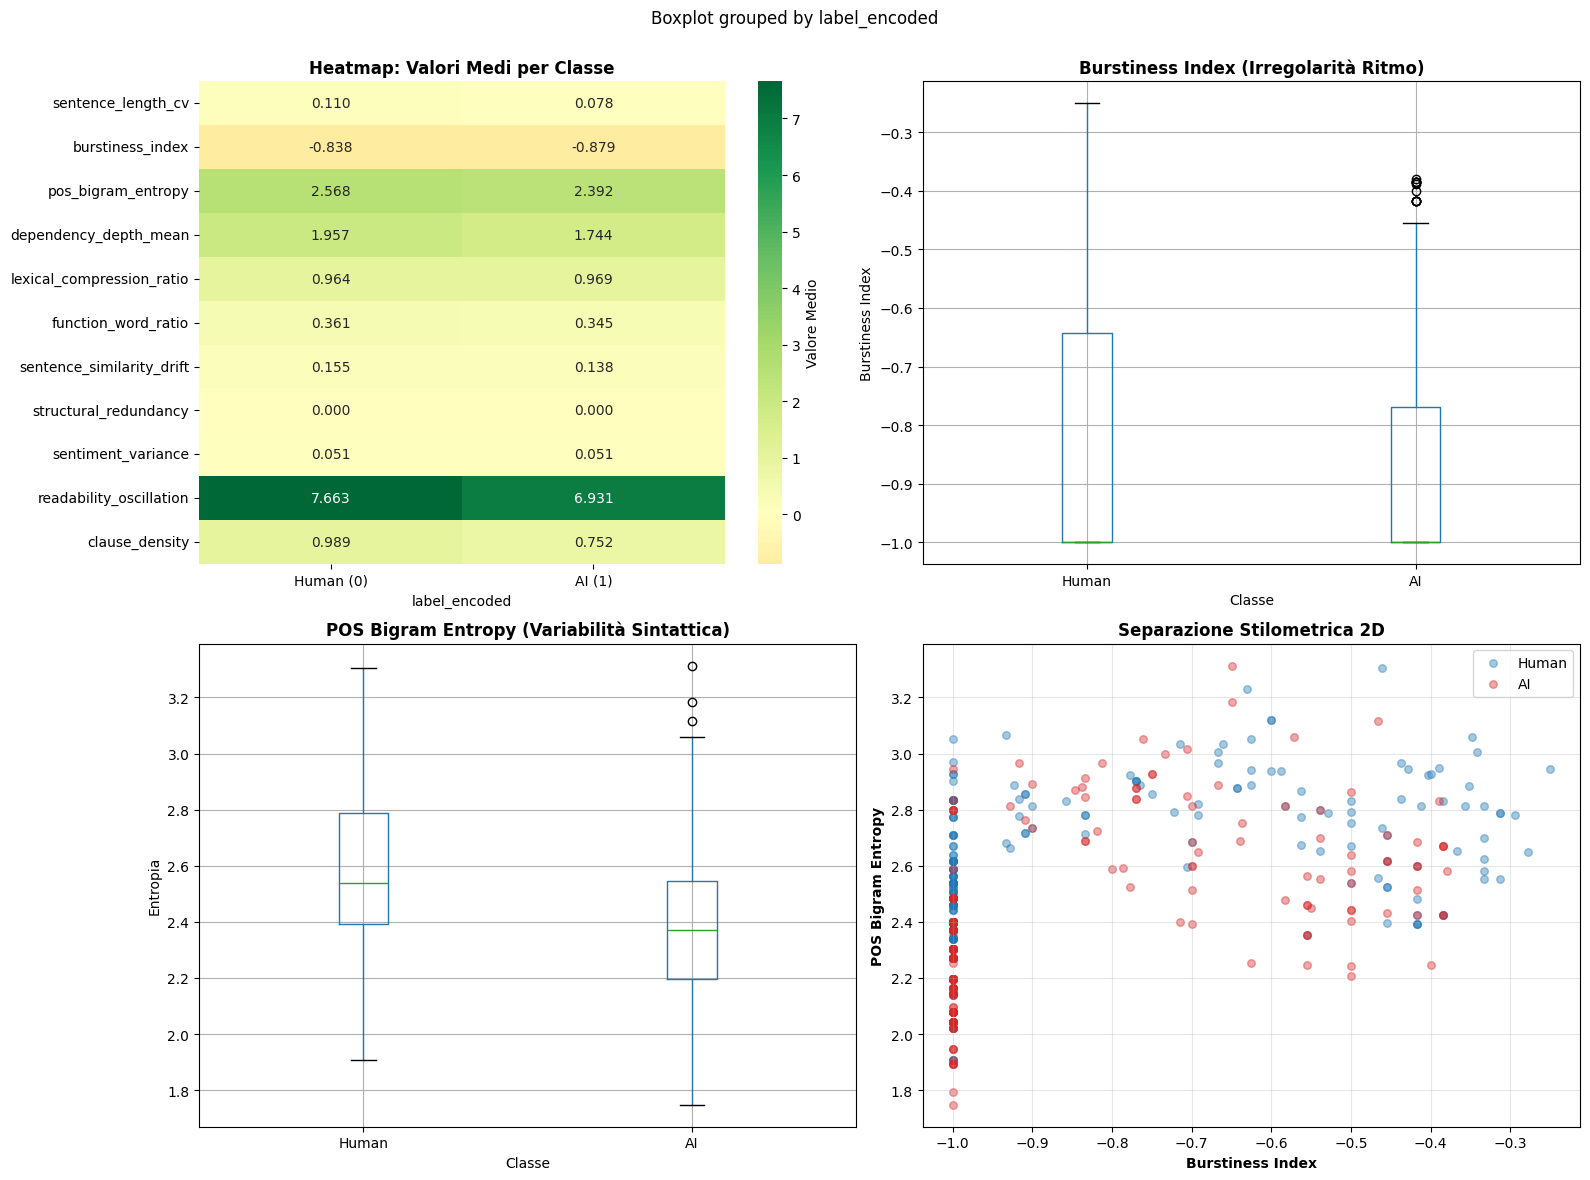

In [63]:
print("\n[6/6] Generazione visualizzazione...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Signature Stilometriche: Confronto AI vs Human', 
             fontsize=18, fontweight='bold')

# --- FIX: Estrazione delle medie per la heatmap ---
# Usiamo .xs per selezionare solo le colonne 'mean' dal livello 1
means = comparison.xs('mean', axis=1, level=1)
comparison_pivot = means.T

# Plot 1: Heatmap comparativa
ax = axes[0, 0]
sns.heatmap(comparison_pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
            center=0, ax=ax, cbar_kws={'label': 'Valore Medio'})
ax.set_title('Heatmap: Valori Medi per Classe', fontweight='bold')
ax.set_xticklabels(['Human (0)', 'AI (1)'])

# Plot 2: Distribuzione burstiness_index
ax = axes[0, 1]
df_final.boxplot(column='burstiness_index', by='label_encoded', ax=ax)
ax.set_title('Burstiness Index (Irregolarità Ritmo)', fontweight='bold')
ax.set_xlabel('Classe')
ax.set_ylabel('Burstiness Index')
# Rinominiamo i tick per chiarezza
ax.set_xticklabels(['Human', 'AI'])
# Rimuoviamo il titolo automatico di pandas che sporca il grafico
plt.suptitle('') 

# Plot 3: Distribuzione pos_bigram_entropy
ax = axes[1, 0]
df_final.boxplot(column='pos_bigram_entropy', by='label_encoded', ax=ax)
ax.set_title('POS Bigram Entropy (Variabilità Sintattica)', fontweight='bold')
ax.set_xlabel('Classe')
ax.set_ylabel('Entropia')
ax.set_xticklabels(['Human', 'AI'])

# Plot 4: Scatter 2D (Burstiness vs Entropy)
ax = axes[1, 1]
for label, color in [(0, '#1f77b4'), (1, '#d62728')]:
    subset = df_final[df_final['label_encoded'] == label]
    label_name = 'Human' if label == 0 else 'AI'
    ax.scatter(subset['burstiness_index'], 
               subset['pos_bigram_entropy'],
               alpha=0.4, s=30, c=color, label=label_name)
ax.set_xlabel('Burstiness Index', fontweight='bold')
ax.set_ylabel('POS Bigram Entropy', fontweight='bold')
ax.set_title('Separazione Stilometrica 2D', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
# Il suptitle deve essere ri-aggiunto dopo tight_layout se no viene sovrapposto
fig.subplots_adjust(top=0.92) 

plt.savefig('signature_validation.png', dpi=300, bbox_inches='tight')
print("✅ Visualizzazione salvata: 'signature_validation.png'")

## SALVATAGGIO DATASET FINALE

In [64]:
output_file = 'ai_human_with_signatures.csv'
df_final.to_csv(output_file, index=False)

print("\n" + "=" * 70)
print("✅ INTEGRAZIONE COMPLETATA CON SUCCESSO!")
print("=" * 70)
print(f"📁 File salvato: '{output_file}'")
print(f"📊 Dimensioni finali: {df_final.shape[0]} righe × {df_final.shape[1]} colonne")
print(f"🎯 Signature aggiunte: {signature_df.shape[1]} feature")

print("=" * 70)


✅ INTEGRAZIONE COMPLETATA CON SUCCESSO!
📁 File salvato: 'ai_human_with_signatures.csv'
📊 Dimensioni finali: 500 righe × 50 colonne
🎯 Signature aggiunte: 11 feature
